In [1]:
from qiskit import QuantumCircuit,transpile
from qiskit.circuit.library import GroverOperator
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython.display import display
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import Sampler

In [2]:
QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="7a7db01ab67f2e9082827e16b71b7ca5230d0c4137133a0c9c28a70c96a12bfc92df1005263db0b17d7885549ea8326c9f04f6f3fb409ff08c633ebff8b59561",
    overwrite=True
)

In [3]:
service = QiskitRuntimeService(channel="ibm_quantum")

# --- 3) Select backend ---
backend_name = "ibm_sherbrooke"
backend = service.backend(name=backend_name)

status = backend.status()
config = backend.configuration()
if not status.operational or config.simulator:
    raise RuntimeError(f"{backend_name} is not operational or not a QPU.")

print(f"[QPU] Running on: {backend.name}")

[QPU] Running on: ibm_sherbrooke


In [4]:
def construct_oracle(marked_state: str) -> QuantumCircuit:
    """Constructs a phase oracle that marks a single binary state.

    Args:
        marked_state (str): A binary string representing the good state (e.g., '101').

    Returns:
        QuantumCircuit: Oracle circuit that flips the phase of the marked state.
    """
    n = len(marked_state)
    oracle = QuantumCircuit(n)

    # Apply X to qubits where the marked bit is 0
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)

    # Apply CCZ using H, CCX, H sequence on the last qubit
    if n == 1:
        oracle.z(0)
    elif n == 2:
        oracle.cz(0, 1)
    else:
        oracle.h(n - 1)
        oracle.mcx(list(range(n - 1)), n - 1)  # multi-controlled X
        oracle.h(n - 1)

    # Uncompute the X gates
    for i, bit in enumerate(marked_state):
        if bit == '0':
            oracle.x(i)

    return oracle

In [5]:
marked_state = '000'  # Change this to any binary string
oracle = construct_oracle(marked_state)


In [6]:
grover_op = GroverOperator(oracle)

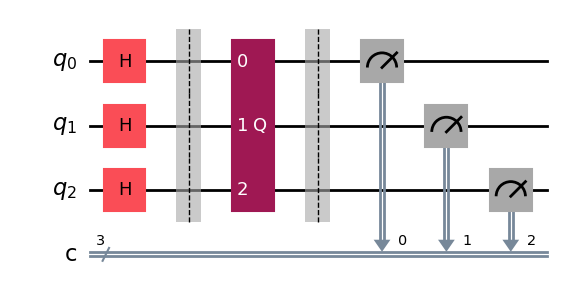

{'101': 29, '110': 35, '100': 37, '001': 33, '011': 25, '111': 38, '010': 26, '000': 801}


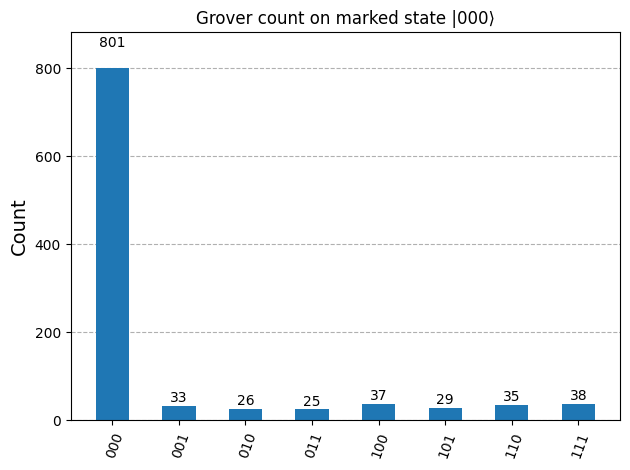

In [7]:
n = len(marked_state)
qc = QuantumCircuit(n, n)
qc.h(range(n))
qc.barrier()
qc.compose(grover_op, inplace=True)
qc.barrier()
qc.measure(range(n), range(n))
display(qc.draw('mpl'))

# --- Step 4: Simulation ---
simulator = AerSimulator()
compiled = transpile(qc, simulator)
result = simulator.run(compiled, shots=1024).result()
counts = result.get_counts()
print(counts)
display(plot_histogram(counts, title=f"Grover count on marked state |{marked_state}⟩"))

Evolved transpiled count_ops: OrderedDict([('rz', 60), ('sx', 31), ('ecr', 19), ('x', 8), ('measure', 3), ('barrier', 2)])
Transpiled circuit ready for submission:


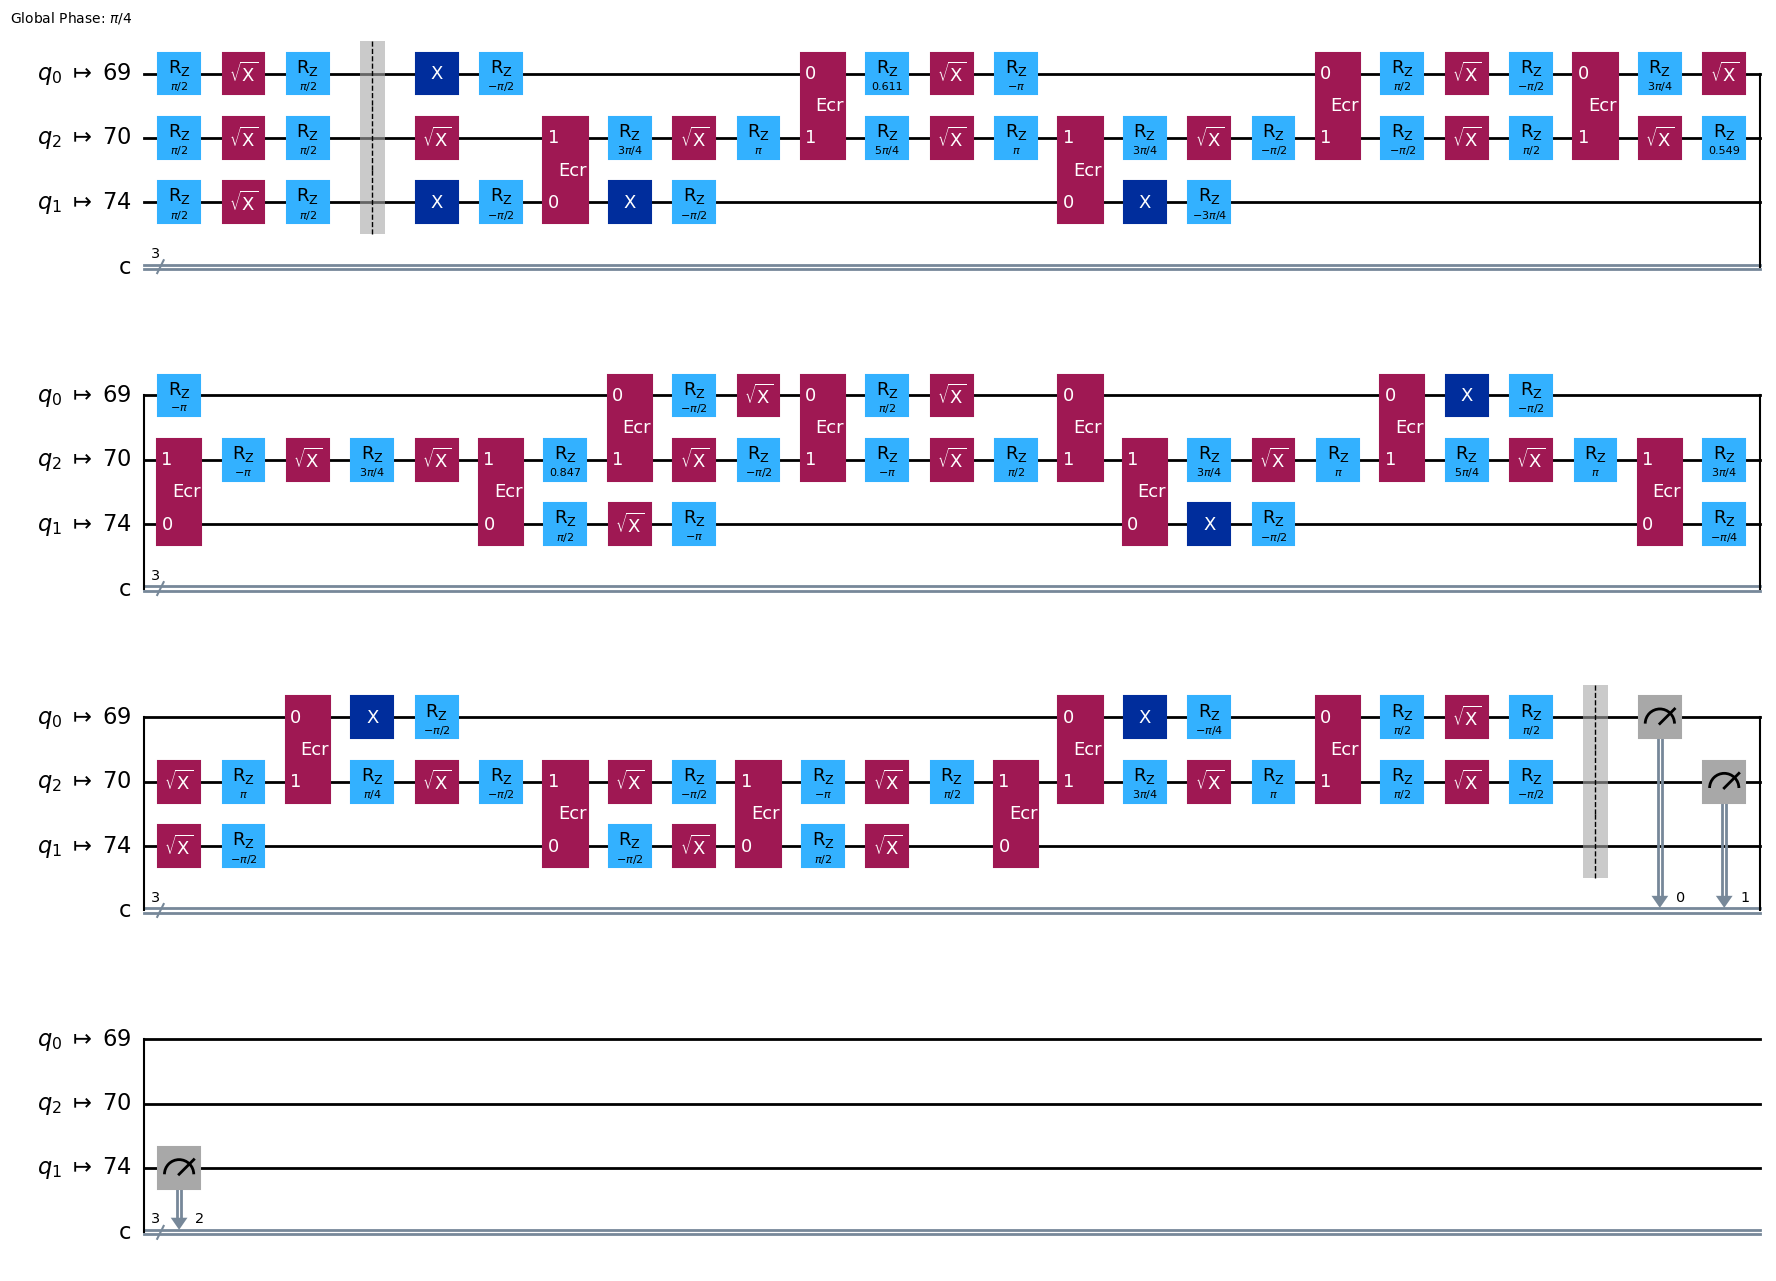

Job ID: d0m7nqet9xxg00892z0g — waiting for result...


In [ ]:
pm = generate_preset_pass_manager(target=backend.target, optimization_level=3)
circuit_isa = pm.run(qc)

ops_evolved = circuit_isa.count_ops()
print("Standard transpiled count_ops:", ops_evolved)

print("Transpiled circuit ready for submission:")
display(circuit_isa.draw(output="mpl", idle_wires=False))
plt.show()



sampler = Sampler(mode=backend)
job = sampler.run([circuit_isa], shots=1024)
print(f"Job ID: {job.job_id()} — waiting for result...")

result = job.result()

In [9]:
try:
    creg = circuit_isa.cregs[0].name if circuit_isa.cregs else "meas"
    counts = getattr(result[0].data, creg).get_counts()
except Exception:
    counts = result[0].data.meas.get_counts()

print("Hardware counts:", counts)

Hardware counts: {'100': 53, '001': 109, '000': 584, '010': 94, '011': 48, '111': 42, '101': 34, '110': 60}


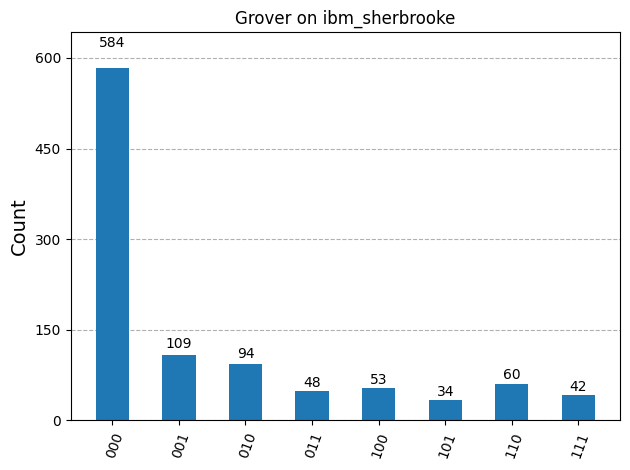

In [10]:
fig = plot_histogram(counts, title=f"Grover on {backend.name}")
display(fig)
plt.show()